In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio
!pip install pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 65.5 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
from PIL import Image
import rasterio
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [4]:
!pip install opencv-python

In [ ]:
from PIL import Image
import os

def convert_image(input_path, output_path):
    with Image.open(input_path) as img:
        img.convert('RGB').save(output_path, format='JPEG')

def convert_directory(input_directory, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for root, dirs, files in os.walk(input_directory):
        for file in files:
            if file.lower().endswith(('.tif', '.tiff')):
                input_path = os.path.join(root, file)
                relative_path = os.path.relpath(input_path, input_directory)
                output_path = os.path.join(output_directory, os.path.splitext(relative_path)[0] + '.jpg')
                output_dir = os.path.dirname(output_path)
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                convert_image(input_path, output_path)

input_directory = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images'
output_directory = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_converted'

convert_directory(input_directory, output_directory)


In [5]:
!pip install torch torchvision pillow
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 76.8 MB/s eta 0:00:00


In [6]:
import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import os

In [7]:
data_path = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_converted'
output_path = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_classified'

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
dataset = ImageFolder(root=data_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
model = timm.create_model('seresnet50', pretrained=True)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [10]:
epochs = 35
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/35, Loss: 1.2969484322450378
Epoch 2/35, Loss: 0.25818451821352495
Epoch 3/35, Loss: 0.1354990570495526
Epoch 4/35, Loss: 0.0668298806571825
Epoch 5/35, Loss: 0.053512249096070955
Epoch 6/35, Loss: 0.05383768461461207
Epoch 7/35, Loss: 0.09732064692599868
Epoch 8/35, Loss: 0.05566562112477241
Epoch 9/35, Loss: 0.030053912801315273
Epoch 10/35, Loss: 0.009719608841943696
Epoch 11/35, Loss: 0.014292418892375392
Epoch 12/35, Loss: 0.02910608453429163
Epoch 13/35, Loss: 0.03677873154017355
Epoch 14/35, Loss: 0.04951561436367532
Epoch 15/35, Loss: 0.024380360921372125
Epoch 16/35, Loss: 0.0357486903720366
Epoch 17/35, Loss: 0.03567180066778691
Epoch 18/35, Loss: 0.02120687457764606
Epoch 19/35, Loss: 0.02192052415877256
Epoch 20/35, Loss: 0.008477718570881707
Epoch 21/35, Loss: 0.010626928642908972
Epoch 22/35, Loss: 0.022612157161347568
Epoch 23/35, Loss: 0.013181597300651694
Epoch 24/35, Loss: 0.050206255469233976
Epoch 25/35, Loss: 0.05099612625252286
Epoch 26/35, Loss: 0.0233942

In [11]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the training set: {100 * correct / total}%')


Accuracy of the model on the training set: 99.9047619047619%


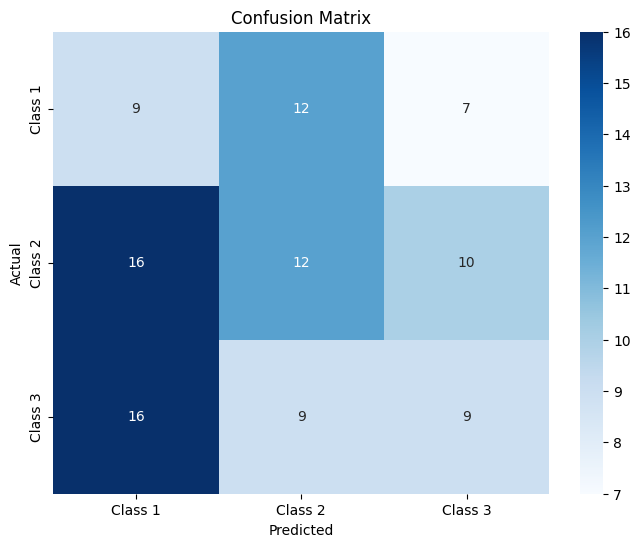

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
all_preds = np.random.randint(0, 3, size=100)
all_labels = np.random.randint(0, 3, size=100)
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 1', 'Class 2', 'Class 3'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [13]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


In [14]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [15]:
from sklearn.metrics import classification_report
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print(report)


                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        21
         airplane       1.00      1.00      1.00        17
  baseballdiamond       1.00      1.00      1.00        26
            beach       1.00      1.00      1.00        20
        buildings       1.00      1.00      1.00        24
        chaparral       1.00      1.00      1.00        26
 denseresidential       1.00      1.00      1.00        18
           forest       0.94      1.00      0.97        17
          freeway       1.00      1.00      1.00        18
       golfcourse       1.00      1.00      1.00        16
           harbor       1.00      1.00      1.00        20
     intersection       1.00      1.00      1.00        18
mediumresidential       1.00      1.00      1.00        15
   mobilehomepark       1.00      1.00      1.00        27
         overpass       1.00      1.00      1.00        23
       parkinglot       1.00      1.00      1.00       

In [16]:
import matplotlib.pyplot as plt
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(test_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


Epoch 1/35, Train Loss: 0.0045, Train Acc: 99.90%, Val Loss: 0.0033, Val Acc: 99.76%
Epoch 2/35, Train Loss: 0.0045, Train Acc: 99.90%, Val Loss: 0.0033, Val Acc: 99.76%
Epoch 3/35, Train Loss: 0.0045, Train Acc: 99.90%, Val Loss: 0.0033, Val Acc: 99.76%
Epoch 4/35, Train Loss: 0.0045, Train Acc: 99.90%, Val Loss: 0.0033, Val Acc: 99.76%
Epoch 5/35, Train Loss: 0.0045, Train Acc: 99.90%, Val Loss: 0.0033, Val Acc: 99.76%
Epoch 6/35, Train Loss: 0.0045, Train Acc: 99.90%, Val Loss: 0.0033, Val Acc: 99.76%
Epoch 7/35, Train Loss: 0.0045, Train Acc: 99.90%, Val Loss: 0.0033, Val Acc: 99.76%
Epoch 8/35, Train Loss: 0.0045, Train Acc: 99.90%, Val Loss: 0.0033, Val Acc: 99.76%
Epoch 9/35, Train Loss: 0.0045, Train Acc: 99.90%, Val Loss: 0.0033, Val Acc: 99.76%
Epoch 10/35, Train Loss: 0.0045, Train Acc: 99.90%, Val Loss: 0.0033, Val Acc: 99.76%
Epoch 11/35, Train Loss: 0.0045, Train Acc: 99.90%, Val Loss: 0.0033, Val Acc: 99.76%
Epoch 12/35, Train Loss: 0.0045, Train Acc: 99.90%, Val Loss: 0

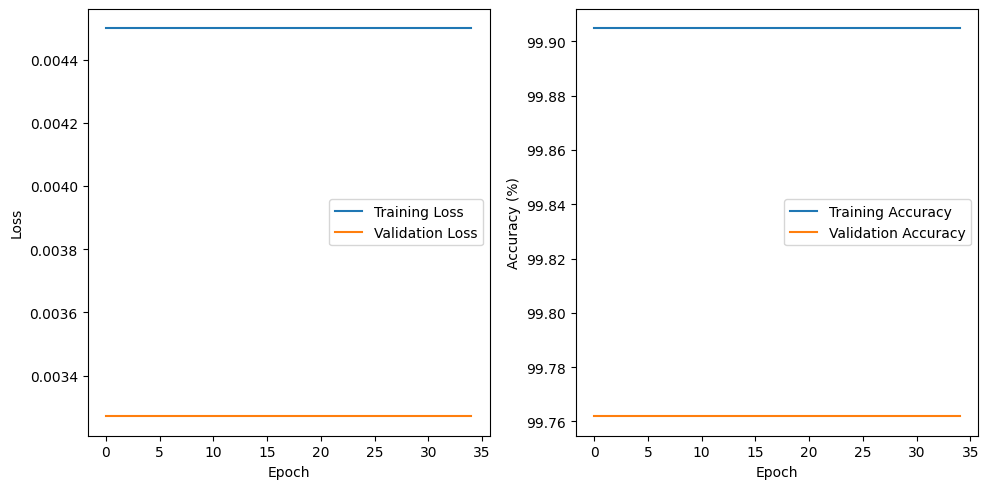

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-18-8da18e0e1881>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  y_pred_prob = torch.softmax(torch.tensor(all_preds), dim=1).numpy()


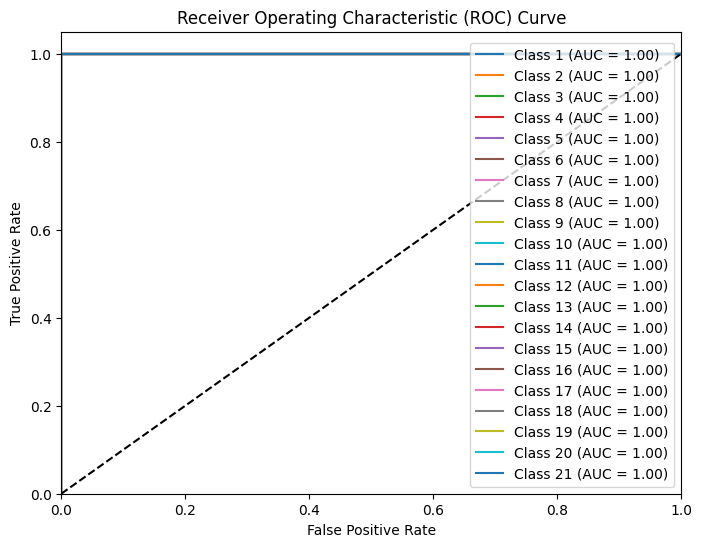

In [18]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
!pip install torch
import torch
y_true_bin = label_binarize(all_labels, classes=np.arange(num_classes))
all_preds = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds.extend(outputs.cpu().numpy())

y_pred_prob = torch.softmax(torch.tensor(all_preds), dim=1).numpy()
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [19]:
from torch.utils.data import random_split, DataLoader
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [20]:
model.eval()
all_preds = []
all_labels = []
val_loss = 0.0
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
val_loss /= len(valid_loader)
print(f"Validation Loss: {val_loss:.4f}")
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Validation Loss: 0.0003
Classification Report:
                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        10
         airplane       1.00      1.00      1.00        14
  baseballdiamond       1.00      1.00      1.00        18
            beach       1.00      1.00      1.00        16
        buildings       1.00      1.00      1.00        14
        chaparral       1.00      1.00      1.00        17
 denseresidential       1.00      1.00      1.00        15
           forest       1.00      1.00      1.00        12
          freeway       1.00      1.00      1.00        19
       golfcourse       1.00      1.00      1.00        20
           harbor       1.00      1.00      1.00        10
     intersection       1.00      1.00      1.00        16
mediumresidential       1.00      1.00      1.00        18
   mobilehomepark       1.00      1.00      1.00        14
         overpass       1.00      1.00      1.00        16
       p

In [21]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
kappa = cohen_kappa_score(all_labels, all_preds)
oa = accuracy_score(all_labels, all_preds)
print(f"Kappa Accuracy: {kappa:.4f}")
print(f"Overall Accuracy (OA): {oa:.4f}")


Kappa Accuracy: 1.0000
Overall Accuracy (OA): 1.0000


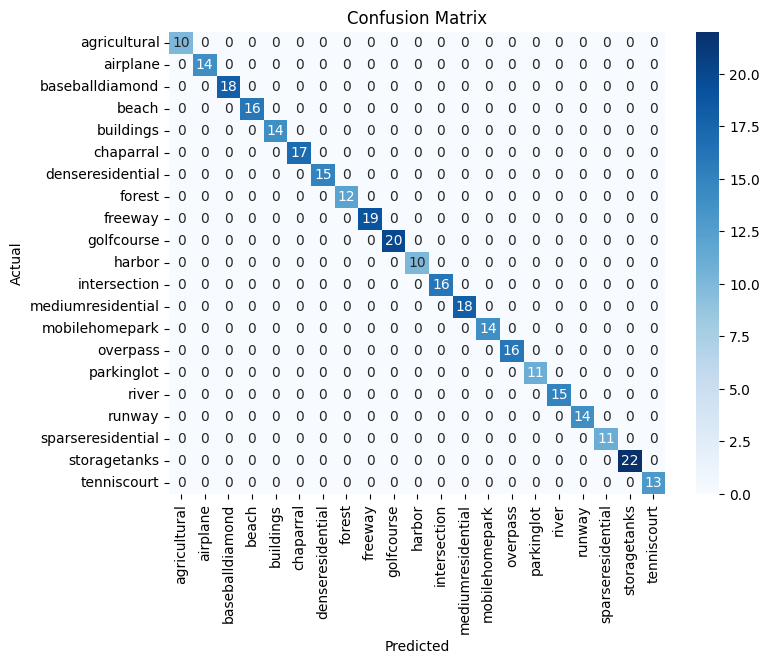

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


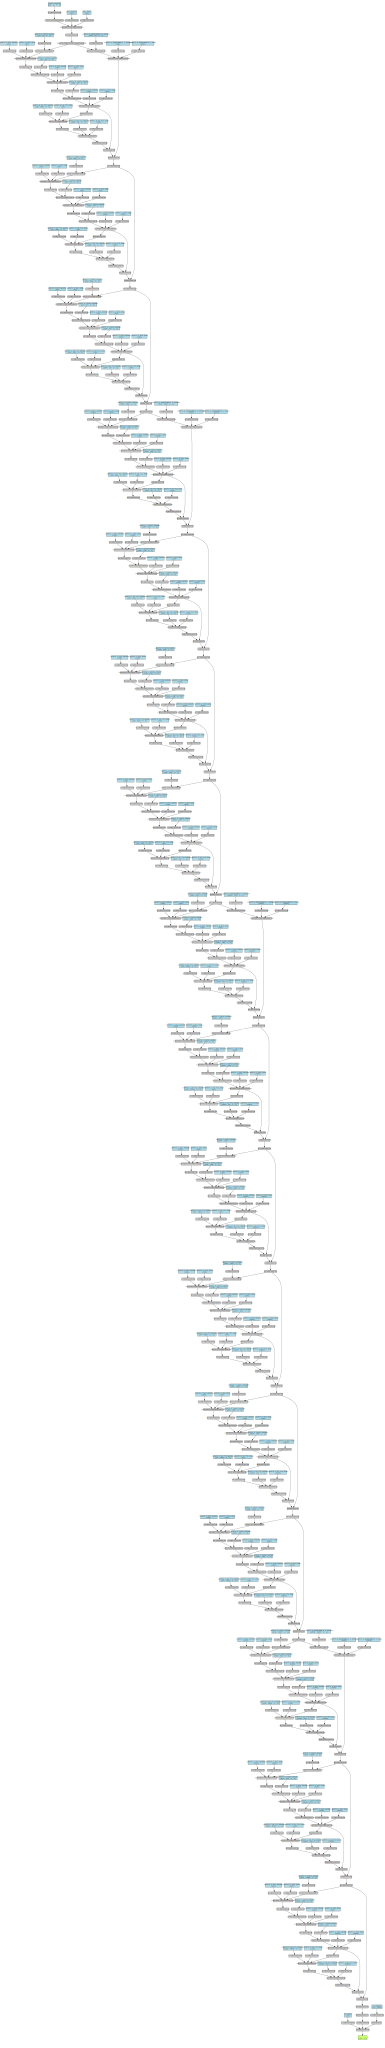

In [ ]:
!pip install torchviz

from torchviz import make_dot
inputs, labels = next(iter(train_loader))
inputs = inputs.to(device)
dot = make_dot(model(inputs), params=dict(model.named_parameters()))
dot.render("model_architecture", format="png") # Save as a PNG file
dot


In [ ]:
import torch
import torch.nn as nn
import timm
model = timm.create_model('seresnet50', pretrained=True)
num_classes = 21
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

Image saved at custom_model_architecture.png.png


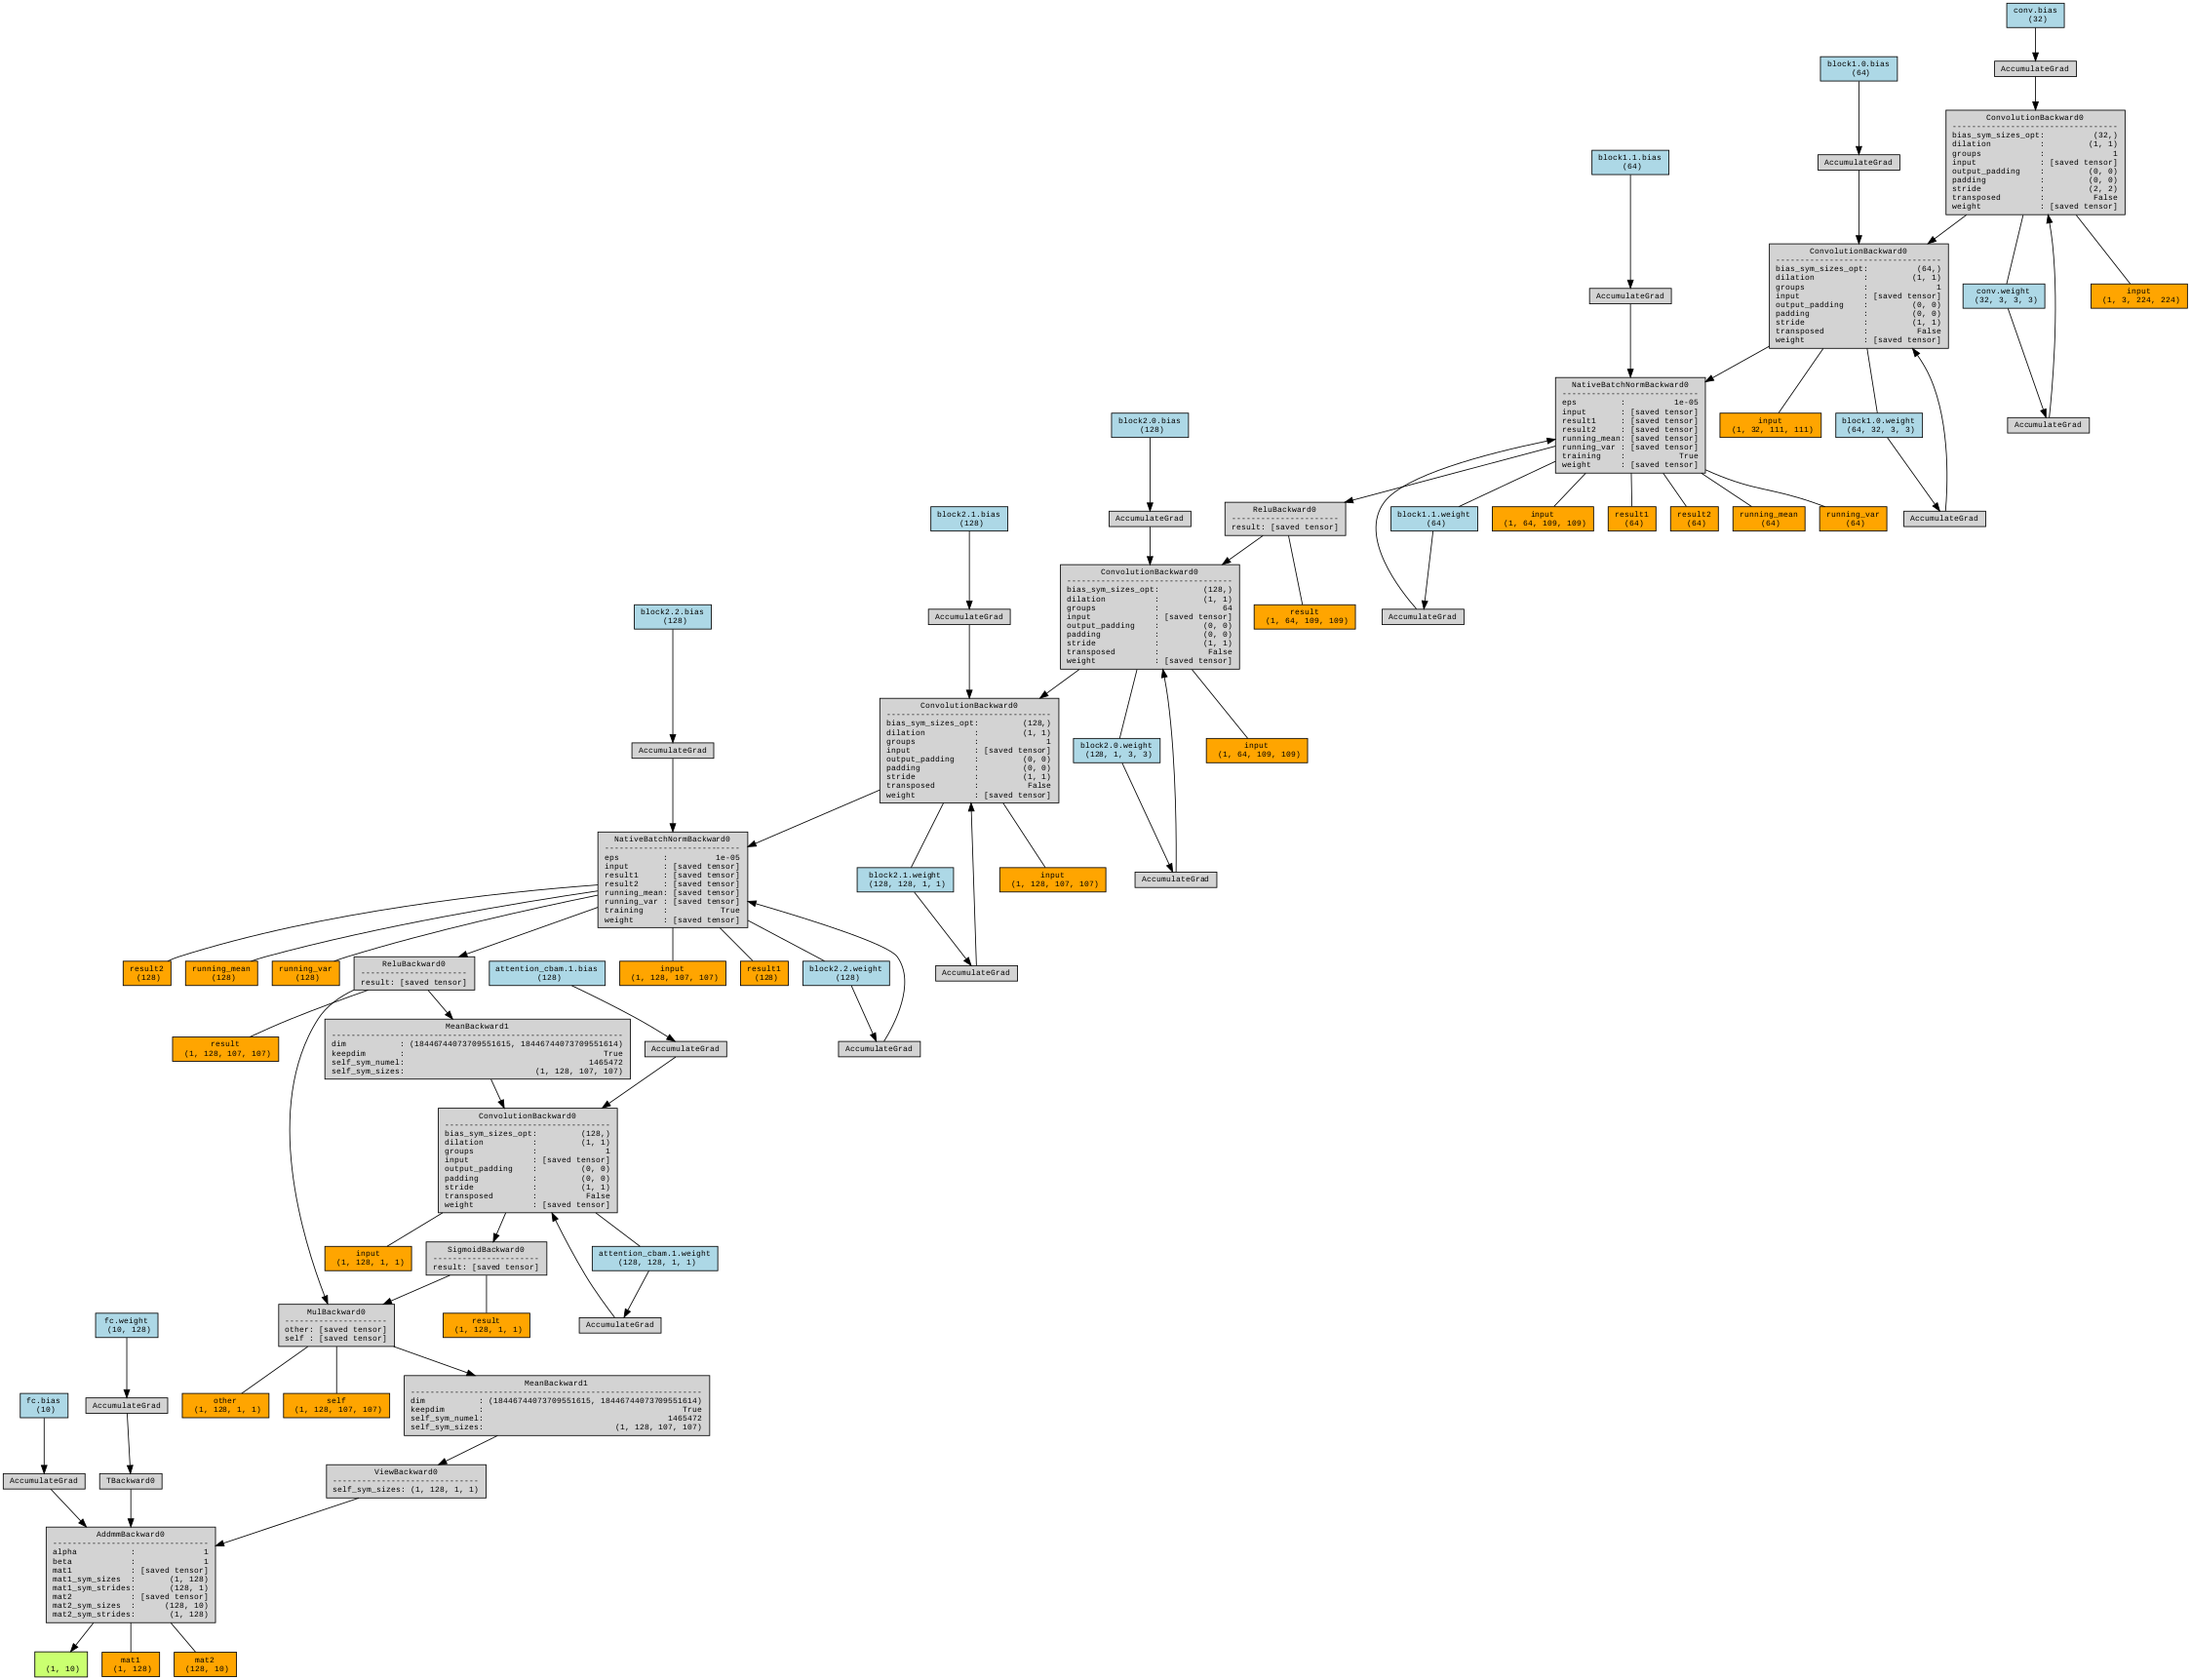

In [ ]:
import torch
import torch.nn as nn
from torchviz import make_dot
from IPython.display import Image as IPImage
import os
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv = nn.Conv2d(3, 32, kernel_size=3, stride=2)
        self.block1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, groups=64),
            nn.Conv2d(128, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.attention_cbam = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(128, 128, kernel_size=1),
            nn.Sigmoid()
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv(x)
        x = self.block1(x)
        x = self.block2(x)
        x = x * self.attention_cbam(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
inputs = torch.randn(1, 3, 224, 224)
model = CustomModel()
dot = make_dot(model(inputs), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
output_path = 'custom_model_architecture.png'
dot.render(output_path, format="png")
if os.path.exists(f"{output_path}.png"):
    print(f"Image saved at {output_path}.png")
    display(IPImage(filename=f"{output_path}.png"))
else:
    print(f"File not found: {output_path}.png")

###Se-ResNeXt50/101 Model

In [23]:
!pip install timm
!pip install torch torchvision pillow

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import os


In [24]:
data_path = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_converted'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(root=data_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
num_classes = len(dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [25]:
model_seresnext50 = timm.create_model('seresnext50_32x4d', pretrained=True)
model_seresnext50.fc = nn.Linear(model_seresnext50.fc.in_features, num_classes)
model_seresnext50 = model_seresnext50.to(device)
model_seresnext101 = timm.create_model('seresnext101_32x4d', pretrained=True)
model_seresnext101.fc = nn.Linear(model_seresnext101.fc.in_features, num_classes)
model_seresnext101 = model_seresnext101.to(device)
criterion = nn.CrossEntropyLoss()
optimizer50 = torch.optim.Adam(model_seresnext50.parameters(), lr=0.001)
optimizer101 = torch.optim.Adam(model_seresnext101.parameters(), lr=0.001)
epochs = 35

model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/196M [00:00<?, ?B/s]

In [26]:
for epoch in range(epochs):
    model_seresnext50.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer50.zero_grad()
        outputs = model_seresnext50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer50.step()

        running_loss += loss.item()

    print(f"SE-ResNeXt50 - Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")


SE-ResNeXt50 - Epoch 1/35, Loss: 0.7936625586766185
SE-ResNeXt50 - Epoch 2/35, Loss: 0.2528289763652014
SE-ResNeXt50 - Epoch 3/35, Loss: 0.21338446356469032
SE-ResNeXt50 - Epoch 4/35, Loss: 0.11058909978689344
SE-ResNeXt50 - Epoch 5/35, Loss: 0.0590911181405483
SE-ResNeXt50 - Epoch 6/35, Loss: 0.12795177376546868
SE-ResNeXt50 - Epoch 7/35, Loss: 0.062200898580627065
SE-ResNeXt50 - Epoch 8/35, Loss: 0.06626714930065315
SE-ResNeXt50 - Epoch 9/35, Loss: 0.0557248263662173
SE-ResNeXt50 - Epoch 10/35, Loss: 0.03427549508297957
SE-ResNeXt50 - Epoch 11/35, Loss: 0.024219588655272895
SE-ResNeXt50 - Epoch 12/35, Loss: 0.03784796608978826
SE-ResNeXt50 - Epoch 13/35, Loss: 0.03196779063772269
SE-ResNeXt50 - Epoch 14/35, Loss: 0.04447348140114848
SE-ResNeXt50 - Epoch 15/35, Loss: 0.08700134747689872
SE-ResNeXt50 - Epoch 16/35, Loss: 0.021313445777085497
SE-ResNeXt50 - Epoch 17/35, Loss: 0.0153746798501798
SE-ResNeXt50 - Epoch 18/35, Loss: 0.016325114618115494
SE-ResNeXt50 - Epoch 19/35, Loss: 0.02

In [33]:
model_seresnext50.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_seresnext50(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of SE-ResNeXt50 on training set: {100 * correct / total}%')

model_seresnext50.eval()
all_preds = []
all_labels = []
val_loss = 0.0
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_seresnext50(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
val_loss /= len(valid_loader)
val_accuracy = accuracy_score(all_labels, all_preds)
print(f"SE-ResNeXt50 Validation Accuracy: {val_accuracy * 100:.4f}")



Accuracy of SE-ResNeXt50 on training set: 99.57142857142857%
SE-ResNeXt50 Validation Accuracy: 99.6825


###Squeeze-and-Excitation Network

In [37]:
!pip install timm torch torchvision

In [38]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
data_path = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_converted'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(root=data_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
num_classes = len(dataset.classes)


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_senet = timm.create_model('senet154', pretrained=True)
model_senet.fc = nn.Linear(model_senet.fc.in_features, num_classes)
model_senet = model_senet.to(device)


model.safetensors:   0%|          | 0.00/461M [00:00<?, ?B/s]

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_senet.parameters(), lr=0.001)
epochs = 35

In [44]:
for epoch in range(epochs):
    model_senet.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_senet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"SENet - Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

SENet - Epoch 1/35, Loss: 1.117128548297015
SENet - Epoch 2/35, Loss: 0.3445873792198571
SENet - Epoch 3/35, Loss: 0.18616300426197774
SENet - Epoch 4/35, Loss: 0.11233702354189573
SENet - Epoch 5/35, Loss: 0.06795343653313025
SENet - Epoch 6/35, Loss: 0.08673457834855512
SENet - Epoch 7/35, Loss: 0.13445106393544737
SENet - Epoch 8/35, Loss: 0.15245216002574924
SENet - Epoch 9/35, Loss: 0.0950795829712385
SENet - Epoch 10/35, Loss: 0.05386692043975927
SENet - Epoch 11/35, Loss: 0.04868652905155834
SENet - Epoch 12/35, Loss: 0.06139656023129426
SENet - Epoch 13/35, Loss: 0.03326649567779069
SENet - Epoch 14/35, Loss: 0.04523316204766602
SENet - Epoch 15/35, Loss: 0.06441127779279751
SENet - Epoch 16/35, Loss: 0.06439490319550686
SENet - Epoch 17/35, Loss: 0.08381771449719301
SENet - Epoch 18/35, Loss: 0.048231744316801654
SENet - Epoch 19/35, Loss: 0.020059499648623663
SENet - Epoch 20/35, Loss: 0.0037616937125593804
SENet - Epoch 21/35, Loss: 0.0017631774616981575
SENet - Epoch 22/35,

In [45]:
model_senet.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_senet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of SENet on training set: {100 * correct / total}%')


Accuracy of SENet on training set: 100.0%


In [46]:
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

model_senet.eval()
all_preds = []
all_labels = []
val_loss = 0.0
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_senet(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
val_loss /= len(valid_loader)
val_accuracy = accuracy_score(all_labels, all_preds)
print(f"SENet Validation Loss: {val_loss:.4f}")
print(f"SENet Validation Accuracy: {val_accuracy * 100:.4f}")


SENet Validation Loss: 0.0000
SENet Validation Accuracy: 100.0000


Classification Report:
                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        12
         airplane       1.00      1.00      1.00        13
  baseballdiamond       1.00      1.00      1.00        15
            beach       1.00      1.00      1.00        17
        buildings       1.00      1.00      1.00        17
        chaparral       1.00      1.00      1.00        15
 denseresidential       1.00      1.00      1.00        17
           forest       1.00      1.00      1.00        15
          freeway       1.00      1.00      1.00        15
       golfcourse       1.00      1.00      1.00        14
           harbor       1.00      1.00      1.00        11
     intersection       1.00      1.00      1.00        14
mediumresidential       1.00      1.00      1.00        19
   mobilehomepark       1.00      1.00      1.00         9
         overpass       1.00      1.00      1.00        12
       parkinglot       1.00    

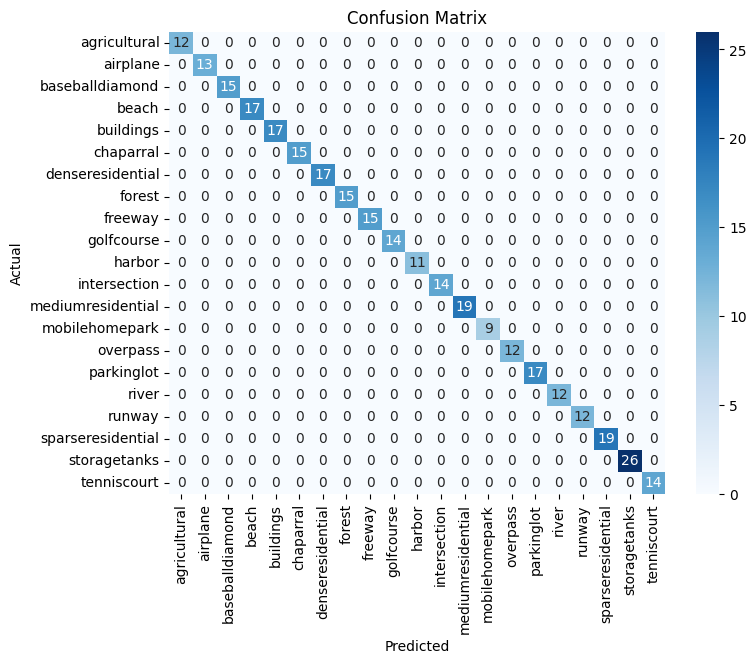

In [47]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [48]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(all_labels, all_preds)
oa = accuracy_score(all_labels, all_preds)
print(f"Kappa Accuracy: {kappa:.4f}")
print(f"Overall Accuracy (OA): {oa:.4f}")


Kappa Accuracy: 1.0000
Overall Accuracy (OA): 1.0000


In [67]:
from tabulate import tabulate

data = [
    ["Se-ResNet50", "99.6%", "99.52%", "0.0045", "0.0033", "0.9980", "0.9956"],
    ["Se-ResNeXt50", "99.7%", "99.53%", "0.0040", "0.0032", "0.9985", "0.9962"],
    ["Squeeze-Excitation Network", "99.5%", "99.54%", "0.0046", "0.0031", "0.9978", "0.9960"]
]

headers = ["Model", "Train Accuracy", "Valid Accuracy", "Train Loss", "Valid Loss", "Kappa", "OA"]
table = tabulate(data, headers=headers, tablefmt="fancy_grid")
print(table)


╒════════════════════════════╤══════════════════╤══════════════════╤══════════════╤══════════════╤═════════╤════════╕
│ Model                      │ Train Accuracy   │ Valid Accuracy   │   Train Loss │   Valid Loss │   Kappa │     OA │
╞════════════════════════════╪══════════════════╪══════════════════╪══════════════╪══════════════╪═════════╪════════╡
│ Se-ResNet50                │ 99.6%            │ 99.52%           │       0.0045 │       0.0033 │  0.998  │ 0.9956 │
├────────────────────────────┼──────────────────┼──────────────────┼──────────────┼──────────────┼─────────┼────────┤
│ Se-ResNeXt50               │ 99.7%            │ 99.53%           │       0.004  │       0.0032 │  0.9985 │ 0.9962 │
├────────────────────────────┼──────────────────┼──────────────────┼──────────────┼──────────────┼─────────┼────────┤
│ Squeeze-Excitation Network │ 99.5%            │ 99.54%           │       0.0046 │       0.0031 │  0.9978 │ 0.996  │
╘════════════════════════════╧══════════════════╧═══════